In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='svg'

from genominterv.decorators import bootstrap
from genominterv.stats import proximity_stat, jaccard_stat
import geneinfo as gi
from geneinfo.utils import GeneList as glist

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from collections import OrderedDict

def plot_intervals(kwargs):

    import matplotlib.pyplot as plt

    vlines = kwargs.get('vlines', [])
    if 'vlines' in kwargs: del kwargs['vlines']
    figsize = kwargs.get('figsize', (8, 1.5*len(kwargs)-1))
    if 'figsize' in kwargs: del kwargs['figsize']

    tups = list(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = np.repeat(label, df.index.size)
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)

    fig, axes = plt.subplots(gr.ngroups, 1, figsize=figsize, 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = [axes]
    
    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), lw=10, colors=f'C{y[0]}', capstyle='butt')
            delta = len(labels)/10

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)

    for y, ax in enumerate(axes):
        y = np.repeat(y, len(vlines))
        axes[i].vlines(vlines, *ax.get_ylim(), lw=0.1, colors='black', zorder=0)
    
    plt.tight_layout()
    return axes

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

## Call compartments and defined edges

In [ ]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(_plot_df.pos, _plot_df.e1, is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='red', linewidth=0.5)


In [ ]:
# e1_100kb = pd.read_csv('rec_compartments/round_spermatid_e1_100kb_arms.csv')
e1_100kb = pd.read_csv('rec_compartments/sperm_e1_100kb_10Mb.csv')
e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
e1_100kb['end'] = e1_100kb.start + 100_000
e1_100kb['sign'] = np.sign(e1_100kb.e1)
e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()

_plot_df = stairs(e1_100kb)
plt.figure(figsize=(15, 6))
plt.fill_between(_plot_df.pos, _plot_df.e1)

from statsmodels.nonparametric.smoothers_lowess import lowess
def add_lowess(x, y, ax=None, color=None, is_sorted=True, frac=0.005, it=0, **kwargs):
    "Add a lowess curve to the plot"
    if ax is None:
        ax = plt.gca() 
    filtered = lowess(y, x, is_sorted=is_sorted, frac=frac, it=it, **kwargs)
    ax.plot(filtered[:,0], filtered[:,1], color='orange', linewidth=0.8)
add_lowess(_plot_df.pos, _plot_df.e1)

# from statsmodels.nonparametric.smoothers_lowess import lowess
# filtered = lowess(_plot_df.pos, _plot_df.e1, is_sorted=True, frac=0.005, it=0)
# plt.plot(filtered[:,0], filtered[:,1], color='red', linewidth=0.5)


sns.despine()

In [ ]:


def pca(matrix, labels=None, n_components=2):
    sklearn_pca = PCA(n_components=n_components)
    sklearn_pca.fit(matrix)
    transform = sklearn_pca.transform(matrix)
    df = pd.DataFrame()
    for i in range(n_components):
        df[f'PC{i+1}'] = transform[:, i]
    if labels is not None:
        df['labels'] = labels
    return df    

In [ ]:
comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
     e1=['mean', 'sum'], 
     start='min', 
     end='max', 
     segment_id='mean', 
     sign='mean'
))
comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
comp = comp.rename(
    columns={'start_min':'start',
             'end_max':'end', 
             'segment_id_mean':'segment_id', 
             'sign_mean':'sign'}
)
comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
comp = comp.reset_index()
comp['chrom'] = 'chrX'

_comp = comp.copy()
for i in range(1, _comp.index.size-1):
    if np.isnan(_comp.loc[i-1, 'e1_mean']):
        _comp.loc[i, 'start'] = np.nan
    if np.isnan(_comp.loc[i+1, 'e1_mean']):
        _comp.loc[i, 'end'] = np.nan
_comp = _comp.loc[~_comp.e1_mean.isnull(), :]
_comp = _comp.reset_index()
compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()

compartments = comp.loc[~comp.e1_mean.isnull()].copy()
compartments['start'] = compartments.start.astype(int)
compartments['end'] = compartments.end.astype(int)

axes = plot_intervals(OrderedDict(
    A=compartments.loc[compartments.comp == 'A', :].copy(),
    B=compartments.loc[compartments.comp == 'B', :].copy(),   
    vlines=compartment_edges.tolist(),
    figsize=(12, 2)
))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(compartments.loc[compartments.e1_mean.abs() > 0 ], x='e1_mean', bins=50, ax=axes[0]) ;
sns.histplot(compartments.loc[compartments.e1_sum.abs() > 0 ], x='e1_sum', bins=50, ax=axes[1]) ;

## rheMac10 chromsome sizes

In [ ]:
chrom_sizes = {
'chr1': 223616942,
'chr2': 196197964,
'chr5': 187317192,
'chr3': 185288947,
'chr6': 179085566,
'chr4': 169963040,
'chr7': 169868564,
'chrX': 153388924,
'chr8': 145679320,
'chr9': 134124166,
'chr11': 133066086,
'chr12': 130043856,
'chr14': 128056306,
'chr15': 113283604,
'chr13': 108737130,
'chr10': 99517758,
'chr17': 95433459,
'chr16': 79627064,
'chr20': 77137495,
'chr18': 74474043,
'chr19': 58315233,
'chrY': 11753682,
}

## Read baboon segments lifted from papanu4 to rheMac10 using segment-liftover

In [ ]:
high_hama_rhemac10 = pd.read_csv('lift/rheMac10/high_hama_rhemac10.bed', sep='\t', 
            header=None, names=['label', 'chrom', 'start', 'end'])
high_hama_rhemac10.head()

In [ ]:
high_olive_rhemac10 = pd.read_csv('lift/rheMac10/high_olive_rhemac10.bed', sep='\t', 
            header=None, names=['label', 'chrom', 'start', 'end'])
high_olive_rhemac10.head()

In [ ]:
ech90_human_Mmul_10 = pd.read_csv('ech90_human_Mmul_10.csv')
ech90_human_Mmul_10.head()

In [ ]:
axes = plot_intervals(OrderedDict(
    Olive=high_olive_rhemac10,   
    Hama=high_hama_rhemac10,
    A=compartments.loc[compartments.comp == 'A', :].copy(),
    B=compartments.loc[compartments.comp == 'B', :].copy(), 
    # ECH90=ech90_human_Mmul_10,
    vlines=compartment_edges.tolist(),
    figsize=(9, 2)
))

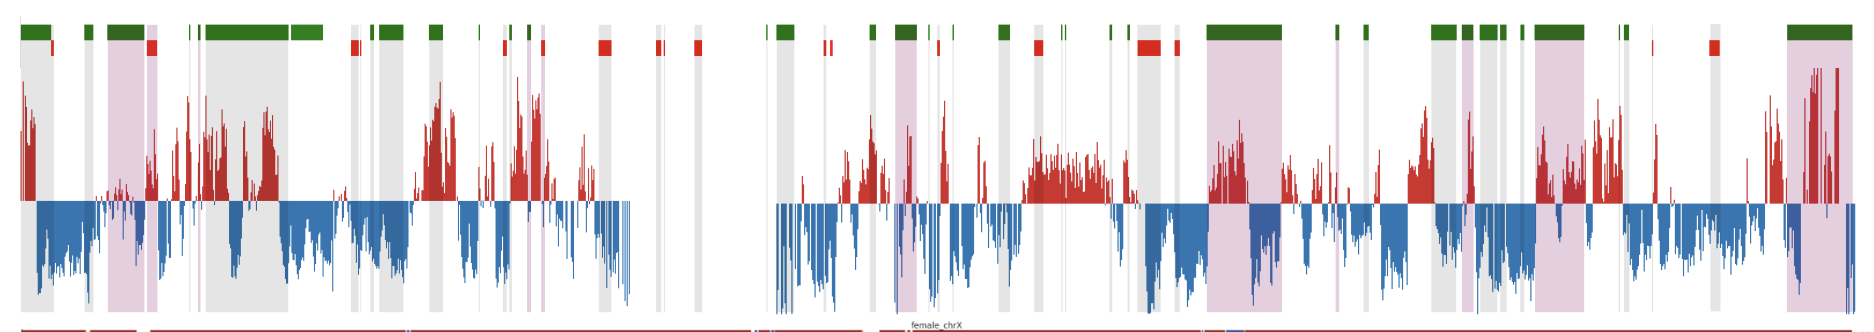

## Make 200kb segments around edges

In [ ]:
flank = 200_000

In [ ]:
compartment_edge_segments = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
compartment_edge_segments['chrom'] = 'chrX'
compartment_edge_segments.head()

In [ ]:
hama_edges = np.concatenate((high_hama_rhemac10.start, high_hama_rhemac10.end))
hama_edge_segments = pd.DataFrame(np.column_stack((hama_edges, hama_edges+flank)), columns=['start', 'end'])
hama_edge_segments.start = np.maximum(hama_edge_segments.start, 0)
hama_edge_segments.end = np.minimum(hama_edge_segments.end, chrom_sizes['chrX']) # rheMac10 chrX length
hama_edge_segments['chrom'] = 'chrX'
hama_edge_segments = hama_edge_segments.sort_values(by=['start', 'end'])
hama_edge_segments.head()

In [ ]:
olive_edges = np.concatenate((high_olive_rhemac10.start, high_olive_rhemac10.end))
olive_edge_segments = pd.DataFrame(np.column_stack((olive_edges, olive_edges+flank)), columns=['start', 'end'])
olive_edge_segments.start = np.maximum(olive_edge_segments.start, 0)
olive_edge_segments.end = np.minimum(olive_edge_segments.end, chrom_sizes['chrX']) # rheMac10 chrX length
olive_edge_segments['chrom'] = 'chrX'
olive_edge_segments = olive_edge_segments.sort_values(by=['start', 'end'])
olive_edge_segments.head()

## Make 1bp segments around edges

In [ ]:
flank = 1

In [ ]:
compartment_edge_1bp = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
compartment_edge_1bp['chrom'] = 'chrX'
compartment_edge_1bp.head()

In [ ]:
hama_edges = np.concatenate((high_hama_rhemac10.start, high_hama_rhemac10.end))
hama_edge_1bp = pd.DataFrame(np.column_stack((hama_edges, hama_edges+flank)), columns=['start', 'end'])
hama_edge_1bp.start = np.maximum(hama_edge_1bp.start, 0)
hama_edge_1bp.end = np.minimum(hama_edge_1bp.end, chrom_sizes['chrX']) # rheMac10 chrX length
hama_edge_1bp['chrom'] = 'chrX'
hama_edge_1bp = hama_edge_1bp.sort_values(by=['start', 'end'])
hama_edge_1bp.head()

In [ ]:
olive_edges = np.concatenate((high_olive_rhemac10.start, high_olive_rhemac10.end))
olive_edge_1bp = pd.DataFrame(np.column_stack((olive_edges, olive_edges+flank)), columns=['start', 'end'])
olive_edge_1bp.start = np.maximum(olive_edge_1bp.start, 0)
olive_edge_1bp.end = np.minimum(olive_edge_1bp.end, chrom_sizes['chrX']) # rheMac10 chrX length
olive_edge_1bp['chrom'] = 'chrX'
olive_edge_1bp = olive_edge_1bp.sort_values(by=['start', 'end'])
olive_edge_1bp.head()

In [ ]:
@bootstrap(chrom_sizes)
def proximity_test(q, a):
    return proximity_stat(q, a)


@bootstrap(chrom_sizes)
def jaccard_test(q, a):
    return jaccard_stat(q, a)


def overlaps(df1, df2):
    """
    Establishes whether each query segment overlaps at least one 
    annotation segment. Returns a boolean array with same length 
    as df1.index.
    """
    overlapping = []
    for i, (s1, e1) in enumerate(zip(df1.start, df1.end)):
        overlaps = False
        for s2, e2 in zip(df2.start, df2.end):
            if e1 > s2 and e2 > s1:
                overlaps = True
                break
        overlapping.append(overlaps)
    return np.array(overlapping)

## Association with compartment edges

In [ ]:
for tissue in ['fibroblast', 'pachytene_spermatocyte', 'round_spermatid', 'sperm', 'spermatogonia']:
    for pc in ['arms', '10Mb', '10Mb_smoothed']:
        for scale in ['100kb', '500kb']:
            file_name = f"rec_compartments/{tissue}_e1_{scale}_{pc}.csv"
            if '500kb_10Mb' in file_name:
                continue
            parse_compartment_data(file_name)

In [ ]:
records = []

for tissue in ['fibroblast', 'pachytene_spermatocyte', 'round_spermatid', 'sperm', 'spermatogonia']:
    for pc in ['arms', '10Mb', '10Mb_smoothed']:
        for scale in ['100kb', '500kb']:

            file_name = f"rec_compartments/{tissue}_e1_{scale}_{pc}.csv"
            if '500kb_10Mb' in file_name:
                continue
            print(file_name)

            compartments, compartment_edges = parse_compartment_data(file_name)
            compartment_edge_segments = edge_segments(compartment_edges, flank=200_000)
            compartment_edge_1bp = edge_segments(compartment_edges, flank=1)
            
            query = ech90_human_Mmul_10
            annot = compartment_edge_segments
            stat, p = jaccard_test(query, annot)
            records.append((tissue, pc, scale, 'ECH90', 'comp_edge_seg', 'jaccard', stat, p))
            print(*records[-1]) 

            query = ech90_human_Mmul_10
            annot = compartment_edge_1bp
            stat, p = jaccard_test(query, annot)
            records.append((tissue, pc, scale, 'ECH90', 'comp_edge_1bp', 'jaccard', stat, p))
            print(*records[-1]) 
            
            query = ech90_human_Mmul_10
            annot = compartment_edge_1bp
            stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
            records.append((tissue, pc, scale, 'ECH90', 'comp_edge_1bp', 'proximity', stat, p))
            print(*records[-1])
            
            query = hama_edge_segments
            annot = compartment_edge_segments
            stat, p = jaccard_test(query, annot)
            records.append((tissue, pc, scale, 'hama_edge_seg', 'comp_edge_seg', 'jaccard', stat, p))
            print(*records[-1])

            query = hama_edge_1bp
            annot = compartment_edge_1bp
            stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
            records.append((tissue, pc, scale, 'hama_edge_1bp', 'comp_edge_1bp', 'proximity', stat, p))
            print(*records[-1])
            
            query = olive_edge_segments
            annot = compartment_edge_segments
            stat, p = jaccard_test(query, annot)
            records.append((tissue, pc, scale, 'olive_edge_seg', 'comp_edge_seg', 'jaccard', stat, p))
            print(*records[-1])
            
            query = olive_edge_1bp
            annot = compartment_edge_1bp
            stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
            records.append((tissue, pc, scale, 'olive_edge_1bp', 'comp_edge_1bp', 'proximity', stat, p))
            print(*records[-1])

            query = pd.concat([olive_edge_1bp, olive_edge_1bp]).sort_values(['start', 'end'])
            annot = compartment_edge_1bp
            stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
            records.append((tissue, pc, scale, 'olivehama_edge_1bp', 'comp_edge_1bp', 'proximity', stat, p))
            print(*records[-1])


all_tests = pd.DataFrame().from_records(records, 
                            columns=['tissue', 'pc_scale', 'win_size', 'query',
                                     'annot', 'test', 'value', 'p'])
all_tests.to_csv('all_tests.csv')

In [ ]:
all_tests = pd.DataFrame().from_records(records, 
                            columns=['tissue', 'pc_scale', 'win_size', 'query',
                                     'annot', 'test', 'value', 'p'])
all_tests.to_csv('all_tests.csv')

In [ ]:
all_tests['-log10p'] = -np.log10(all_tests.p) 
df = (all_tests
 .assign(log10p=np.log10(all_tests.p))
 .loc[(all_tests.p < 0.05) 
      & (all_tests.win_size == '100kb') 
      & all_tests['query'].isin(['ECH90', 'olivehama_edge_1bp'])
      & (all_tests['annot'] == 'comp_edge_1bp')
      & all_tests['pc_scale'].isin(['arms', '10Mb'])
      , ['tissue', 'pc_scale', 'query', 'test', 'value', 'p', '-log10p']]
     )
                                   
df.pivot(index=['pc_scale', 'query', 'test' ], columns=["tissue"], values="-log10p").fillna('-')

In [ ]:
df = (all_tests
 .assign(log10p=np.log10(all_tests.p))
 .loc[(all_tests.p < 0.05) 
      & (all_tests.win_size == '100kb') 
      & all_tests['query'].isin(['ECH90', 'olivehama_edge_1bp'])
      & (all_tests['annot'] == 'comp_edge_1bp')
      & all_tests['pc_scale'].isin([10Mb'])
      , ['tissue', 'pc_scale', 'query', 'test', 'value', 'p', 'log10p']]
).sort_values(by=['tissue', 'query', 'test'])
df.style.background_gradient(subset = ["log10p"], 
# df.style.text_gradient(subset = ["log10p"], 
                       cmap = "Reds_r", 
                       # vmin = df.log10p.min(), 
                       # vmax = df.log10p.max()
                      )


In [ ]:
df = (all_tests
 .assign(log10p=np.log10(all_tests.p))
 .loc[(all_tests.p < 0.05) 
      & (all_tests.win_size == '100kb') 
      & all_tests['query'].isin(['ECH90', 'olivehama_edge_1bp'])
      & (all_tests['annot'] == 'comp_edge_1bp')
      & all_tests['pc_scale'].isin(['arms'])
      , ['tissue', 'pc_scale', 'query', 'test', 'value', 'p', 'log10p']]
).sort_values(by=['tissue', 'query', 'test'])
df.style.background_gradient(subset = ["log10p"], 
# df.style.text_gradient(subset = ["log10p"], 
                       cmap = "Reds_r", 
                       # vmin = df.log10p.min(), 
                       # vmax = df.log10p.max()
                      )


In [ ]:
with pd.option_context('display.max_rows', None,):
    display(all_tests.loc[(all_tests.p < 0.05) & all_tests['query'].isin(['ECH90', 'olivehama_edge_1bp'])])

### ECH90

In [ ]:
query = ech90_human_Mmul_10
annot = compartment_edge_segments
stat, p = jaccard_test(query, annot)
print('Jaccard overlap test:', stat, p)
stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
print('Mean dist test:', stat, p)

### 95% pure hamadryas regions

In [ ]:
query = hama_edge_segments
annot = compartment_edge_segments
stat, p = jaccard_test(query, annot)
print('Jaccard overlap test:', stat, p)

query = hama_edge_1bp
annot = compartment_edge_1bp
stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
print('Mean dist test:', stat, p)

### 100% pure olive regions

In [ ]:
query = olive_edge_segments
annot = compartment_edge_segments
stat, p = jaccard_test(query, annot)
print('Jaccard overlap test:', stat, p)

query = olive_edge_1bp
annot = compartment_edge_1bp
stat, p = proximity_test(query.loc[~overlaps(query, annot)], annot)
print('Mean dist test:', stat, p)

In [ ]:
def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect.bisect_right(a, x)
    if i:
        return i-1
    raise ValueError

def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect.bisect_left(a, x)
    if i != len(a):
        return i
    raise ValueError

import bisect
bisect.bisect_right([1, 2, 3, 4, 4, 5, 6], 4) # le
len([1, 2, 3, 4, 4, 5, 6]) - bisect.bisect_left([1, 2, 3, 4, 4, 5, 6], 4) # ge

In [ ]:
query = high_olive_rhemac10
annot = compartment_edge_1bp
from genominterv.remapping import remap, remap_interval_data

@bootstrap(chrom_sizes, samples=10000, return_boot=True, smaller=True)
def statistic(query, annot):
    stats = []
    for t in query.itertuples():
        if not (t.start and t.end):
            continue
        a = remap((t.start, t.start), list(zip(annot.start, annot.end)), relative=True)
        b = remap((t.end, t.end), list(zip(annot.start, annot.end)), relative=True)
        if a and b:
            a = abs(a[0][0])
            b = abs(b[0][0])
            if np.isnan(a) or np.isnan(b):
                continue
#            print(a, b)
            
#            stats.append(1 / abs((a * b)) if a and b else 100)
            # stats.append((np.log1p(a) * np.log1p(b) if np.log1p(a) and np.log1p(b) else 2))
            # stats.append(a * b)
            # stats.append(a * b)
            stats.append(a)
            stats.append(b)

    #             stats.append(
#               int(abs(a) < 200_000 and abs(b) < 200_000)              
# #             1 - (np.exp(np.log1p(0.001) + np.log1p(0.1)) - 1)
#             )
        # else:
        #     print(a, b)

    return sum(stats)

stat, p, boot = statistic(query, annot)
stat, p
# statistic(query, annot)


In [ ]:
plt.hist(boot)
#plt.axvline(stat, color='red')
plt.axvline(stat, *plt.gca().get_ylim(), color='red')

In [ ]:
np.log10(0.001)

In [ ]:
1 - (np.exp(np.log1p(0.001) * np.log1p(0.1)) - 1)

In [ ]:
1/(0.1 * 0.02)

In [ ]:
from genominterv.stats import jaccard_stat, proximity_stat
from genominterv.decorators import bootstrap

@bootstrap(chrom_sizes, samples=1000)
def statistic(compartments, win_means):

    purities = []
    for t in compartments.itertuples():
        north_sum = win_means.loc[(win_means.start >= t.start) & (win_means.end <= t.end)].north_sum 
        if len(north_sum):
            prop_north_sum = north_sum / 100_000
            mean_prop = prop_north_sum.mean()        
            # purities.append(int(1-mean_prop > 0.75))
            # purities.append(max(mean_prop, 1-mean_prop))
            # purities.append(max(mean_prop, 1-mean_prop) > 0.80)
            # purities.append(mean_prop < 0.329/2 or mean_prop > 0.329*2)
            purities.append(np.maximum(prop_north_sum, 1-prop_north_sum).mean())
    
    return np.mean(np.array(purities))
        
statistic(compartments, win_means.loc[~np.isnan(win_means.north_sum)])

## Genes overlapping ECH vs. Compartment edges

In [ ]:
sojern_genes = glist([
    'AKAP4', 'ALG13', 'ATP7A', 'ATRX', 'BRCC3', 'CCNB3', 'CENPVL3', 'CLCN5', 'CLCN5', 
    'CMC4', 'COX7B', 'CYBB', 'DKC1', 'DYNLT3', 'ENOX2', 'F8', 'FAM120C', 'FUNDC2', 'H2AFB3', 
    'LANCL3', 'LAS1L', 'LOC114675151', 'LOC114675176', 'LOC114675180', 'LOC114675218', 
    'LOC114675231', 'LOC114675302', 'LOC695959', 'LOC696657', 'LOC703257', 'LOC706958', 
    'MAGT1', 'MIR188', 'MIR362', 'MIR500A', 'MIR500B', 'MIR501', 'MIR502', 'MIR532', 'MIR660',
    'MIR7206', 'MPP1', 'MSN', 'MTCP1', 'PAGE4', 'RAP2C', 'SH3KBP1', 'SMIM9', 'TRPC5', 'USP27X', 
    'WNK3', 'XK', 'ZC3H12B' 
])
sojern_genes

In [ ]:
from geneinfo.utils import GoogleSheet, nice
google_sheet = GoogleSheet()

In [ ]:
list(google_sheet)

In [ ]:
[
 'meritxell_spermatid_expr',
 'mult_copy',
 'all_post_mei_expr',
 'msci',
 'msci_esc',
 'my_primate_codeml',
 'cDEG',
 'nDEG',
 'primate_ampl_multi',
 'gametologs',
 'xi',
 'xi_escape',
 'xi_uncertain',
 'xi_any_evidence',
 'expr_mod_xi_copynr_fibrobl',
 'expr_mod_xi_copynr_lcl',
 'ari_relate_EUR',
 'ari_relate_ASIA',
 'ari_relate_AFR',
 'ech90_regions',
 'accel_reg_simiiformes_br'
]
 

In [ ]:
test_lists = [
 'xi_escape',
 'meritxell_spermatid_expr',
    
 'expr_mod_xi_copynr_fibrobl',
     'accel_reg_simiiformes_br',
 'my_primate_codeml',

 # 'ari_all',
     'mult_copy',

]
 

In [ ]:
from upsetplot import UpSet
from upsetplot import from_contents

# d = dict((n, list(google_sheet.get(n))) for n in test_lists)
# d['sojern_genes'] = list(sojern_genes)
# ax_dict = UpSet(from_contents(d),
#                 show_counts=True).plot()

In [ ]:

gene_list = []
for list_name in test_lists:
    gene_list.extend(google_sheet.get(list_name))
df = pd.DataFrame(dict(genes=sorted(set(gene_list))))
for list_name in test_lists:
    df[list_name] = df.genes.isin(google_sheet.get(list_name))

df['sojern_genes'] = df.genes.isin(sojern_genes)

df = df.set_index(test_lists + ['sojern_genes'])

from upsetplot import UpSet
ax_dict = UpSet(df.genes, show_counts=True, subset_size="count").plot()

# get list of all genes
# iter list of all genes_list_sets
#     iter all lists
#         add coilumn
#         column = gene.isin(gene_list_Set)

# set index to new columns

# for list_name in test_lists:
#     genes = google_sheet.get(list_name)
    

In [ ]:
from scipy.stats import fisher_exact

background_set = set(google_sheet.get('all_npx'))
set_a = set(google_sheet.get('meritxell_spermatid_expr'))
set_b = set(sojern_genes)

# ASD-related genes are more likely to be expressed in brain+spermatids than in only brain
M = len(background_set) 
N = len(background_set.intersection(set_a)) 
n = len(background_set.intersection(set_b))
x = len(background_set.intersection(set_b).intersection(set_a))

table = [[  x,           n - x          ],
         [ N - x,        M - (n + N) + x]]
table, fisher_exact(table, alternative='greater').pvalue


In [ ]:
list(google_sheet)

In [ ]:
google_sheet.get('ari_relate_AFR')

In [ ]:
from upsetplot import generate_counts
example = generate_counts()
example

In [ ]:
gi.gene_info(genes)

# THIS DOES NOT MAKE SENSE BECUASE THE LAI ARE IN PAPANU4 AND THE COMPARTMENTS ARE IN RHEMAC10

## Read in baboon LAI

In [ ]:
df = pd.read_hdf('mean_window_df_eth.h5')
meta_data_samples = pd.read_csv("Papio_metadata_with_clustering.txt", sep =" ")
gog_olives = meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia"].PGDP_ID
chrX_lai_eth = df.loc[df.individual.isin(gog_olives) & (df.chrom == 'all_chrX')].groupby(["chrom", "individual", "start", "end"]).mean().reset_index()
chrX_lai_eth.head()

In [ ]:
win_means = chrX_lai_eth.groupby(['start', 'end']).north_sum.mean().reset_index()
win_means.head()

In [ ]:
plot_df = stairs(win_means)
plt.figure(figsize=(12, 4))
plt.fill_between(plot_df.pos, plot_df.north_sum)

In [ ]:
compartments['mean_north_sum'] = [win_means.loc[(win_means.start >= t.start) & (win_means.end <= t.end), :].north_sum.mean() for t in compartments.itertuples()]

In [ ]:
1 - win_means.north_sum.mean() / 100000

In [ ]:
sns.barplot(compartments, x='start', y='mean_north_sum')
plt.axhline(y=win_means.north_sum.mean()) ;

In [ ]:
sns.histplot(compartments.mean_north_sum, bins=np.linspace(0, 100000, 50)) ;

In [ ]:
compartments

In [ ]:
chrom_sizes = {
'chr1':	227556264,
'chr2':	192460366,
'chr3':	192294377,
'chr5':	189454096,
'chr6':	181584905,
'chr7':	171882078,
'chr4':	170955103,
# 'chrX':	152835861,
'chrX':	153300000,
'chr8':	146850525,
'chr11':	137757926,
'chr9':	133195287,
'chr12':	132586672,
'chr14':	130733371,
'chr15':	112612857,
'chr13':	111193037,
'chr17':	96864807,
'chr10':	96509753,
'chr16':	80997621,
'chr20':	78541002,
'chr18':	75711847,
'chr19':	59248254,
}

In [ ]:
from genominterv.stats import jaccard_stat, proximity_stat
from genominterv.decorators import bootstrap

@bootstrap(chrom_sizes, samples=1000)
def statistic(compartments, win_means):

    purities = []
    for t in compartments.itertuples():
        north_sum = win_means.loc[(win_means.start >= t.start) & (win_means.end <= t.end)].north_sum 
        if len(north_sum):
            prop_north_sum = north_sum / 100_000
            mean_prop = prop_north_sum.mean()        
            # purities.append(int(1-mean_prop > 0.75))
            # purities.append(max(mean_prop, 1-mean_prop))
            # purities.append(max(mean_prop, 1-mean_prop) > 0.80)
            # purities.append(mean_prop < 0.329/2 or mean_prop > 0.329*2)
            purities.append(np.maximum(prop_north_sum, 1-prop_north_sum).mean())
    
    return np.mean(np.array(purities))
        
statistic(compartments, win_means.loc[~np.isnan(win_means.north_sum)])

In [ ]:
edge_segments = pd.DataFrame(np.column_stack((edges-100_000, edges+100_000)), columns=['start', 'end'])
edge_segments['chrom'] = 'chrX'
edge_segments

In [ ]:

@bootstrap('hg38')
def proximity_test(q, a):

    return proximity_stat(q, a)


@bootstrap('hg38')
def jaccard_test(q, a):

    return jaccard_stat(q, a)


def overlaps(df1, df2):
    """
    Establishes whether each query segment overlaps at least one 
    annotation segment. Returns a boolean array with same length 
    as df1.index.
    """
    overlapping = []
    for i, (s1, e1) in enumerate(zip(df1.start, df1.end)):
        overlaps = False
        for s2, e2 in zip(df2.start, df2.end):
            if e1 > s2 and e2 > s1:
                overlaps = True
                break
        overlapping.append(overlaps)
    return np.array(overlapping)


stat, p = jaccard_test(query, annot)
print('Jaccard overlap test:', stat, p)

query_non_ovl = query.loc[~overlaps(query, annot)]   
stat, p = mean_dist_test(query_non_ovl, annot)
print('Mean dist test:', stat, p)